In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from statsmodels.api import OLS, add_constant

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
data = pd.read_csv("data/fixed_data.csv")
data

,AUN_SUM,HEALTH,K6SCMON,Treatment,Post,AGE2,IRSEX,INCOME,IRMARIT,SERVICE,CG30EST,AL30EST,IRHHSIZ2,NOBOOKY2,COCFLAG,COCYR,EDUCCAT2,JBSTATR2,TXEVER,TXYREVER
0,0.0,3.0,9.0,1,1,0.666667,2,1.000000,4,2.0,0.0,0.0,0.8,0.0,1,0,0.75,0.0,1.0,1.0
1,0.0,5.0,0.0,0,1,0.333333,1,0.000000,4,1.0,0.0,0.0,0.2,0.0,0,0,0.25,6.0,1.0,1.0
2,0.0,5.0,4.0,1,1,0.333333,2,0.333333,4,2.0,0.0,0.0,0.4,0.0,0,0,1.00,0.0,1.0,1.0
3,0.0,3.0,0.0,0,1,0.666667,2,0.000000,1,2.0,0.0,0.0,1.0,0.0,0,0,0.25,8.0,1.0,1.0
4,0.0,3.0,3.0,0,1,0.333333,1,0.333333,4,2.0,0.0,0.0,0.6,0.0,0,0,0.75,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602944,0.0,4.0,2.0,1,0,0.333333,1,1.000000,4,2.0,0.0,0.0,0.8,0.0,0,0,0.75,3.0,1.0,1.0
602945,0.0,5.0,0.0,0,0,0.333333,2,0.333333,1,2.0,0.0,0.0,0.6,0.0,0,0,0.50,8.0,1.0,1.0
602946,0.0,4.0,0.0,1,0,0.666667,2,1.000000,1,2.0,0.0,0.0,0.4,0.0,0,0,0.75,0.0,1.0,1.0
602947,0.0,4.0,1.0,0,0,0.333333,1,1.000000,4,2.0,0.0,0.0,0.4,0.0,1,0,0.50,1.0,0.0,0.0


In [3]:
# 결과 변수 목록
numeric_outcomes = ["AUN_SUM", "HEALTH", "K6SCMON"]

# 결과 저장
results = {}

# 수치형 결과 변수 처리
for outcome in numeric_outcomes:
    print(f"Estimating effect for numeric outcome (DiD + Parametric): {outcome}")

    # 변수 설정 (전체 데이터 사용)
    Y = data[outcome]
    T = data["Treatment"]
    Post = data["Post"]  # DiD의 시간 변수
    X = data.drop(columns=["Treatment", "Post"] + numeric_outcomes)

    # 성향 점수 계산 (Propensity Score)
    prop_model = LogisticRegression()
    prop_model.fit(X, T)
    propensity_scores = prop_model.predict_proba(X)[:, 1]

    # 처치와 성향 점수 추가
    X_with_ps = X.copy()
    X_with_ps['Propensity'] = propensity_scores
    X_with_ps['Post'] = Post
    X_with_ps['Treatment_Post'] = T * Post

    # 회귀 분석 (OLS)
    X_ols = add_constant(X_with_ps[['Propensity', 'Post', 'Treatment_Post']])
    ols_model = OLS(Y, X_ols).fit()

    # ATE 추정
    ate = ols_model.params['Treatment_Post']
    ci = ols_model.conf_int().loc['Treatment_Post']

    # 결과 저장
    results[outcome] = {
        "ATE": ate,
        "CI": (ci[0], ci[1])
    }

    print(f"ATE for {outcome}: {ate}, CI: ({ci[0]}, {ci[1]})\\n")

# 최종 결과 출력
for outcome, result in results.items():
    print(f"Outcome: {outcome}, ATE: {result['ATE']}, CI: {result['CI']}")


Estimating effect for numeric outcome (DiD + Parametric): AUN_SUM
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
ATE for AUN_SUM: 0.08634042857418088, CI: (0.06273260138589327, 0.10994825576246849)\n
Estimating effect for numeric outcome (DiD + Parametric): HEALTH
ATE for HEALTH: 0.10662934205781546, CI: (0.10033774036428411, 0.11292094375134681)\n
Estimating effect for numeric outcome (DiD + Parametric): K6SCMON
ATE for K6SCMON: -0.18159113152565695, CI: (-0.2144260936461247, -0.1487561694051892)\n
Outcome: AUN_SUM, ATE: 0.08634042857418088, CI: (0.06273260138589327, 0.10994825576246849)
Outcome: HEALTH, ATE: 0.10662934205781546, CI: (0.10033774036428411, 0.11292094375134681)
Outcome: K6SCMON, ATE: -0.18159113152565695, CI: (-0.2144260936461247, -0.1487561694051892)


# DiD Assumptions?

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 사전(pre-treatment) 기간 데이터 필터링
pre_data = data[data["Post"] == 0]

# 처치 그룹과 비처치 그룹의 평균 결과 변수 계산
parallel_check = {}
for outcome in numeric_outcomes:
    treated_mean = pre_data[pre_data["Treatment"] == 1][outcome].mean()
    control_mean = pre_data[pre_data["Treatment"] == 0][outcome].mean()
    parallel_check[outcome] = {
        "Treated Mean": treated_mean,
        "Control Mean": control_mean,
        "Difference": treated_mean - control_mean
    }

# 결과 출력
print("\nParallel Trends Pre-Treatment Check:")
for outcome, stats in parallel_check.items():
    print(f"{outcome}: Treated Mean = {stats['Treated Mean']:.4f}, "
          f"Control Mean = {stats['Control Mean']:.4f}, "
          f"Difference = {stats['Difference']:.4f}")


Parallel Trends Pre-Treatment Check:
AUN_SUM: Treated Mean = 0.5106, Control Mean = 0.4755, Difference = 0.0351
HEALTH: Treated Mean = 3.9396, Control Mean = 3.6262, Difference = 0.3134
K6SCMON: Treated Mean = 5.1088, Control Mean = 5.9721, Difference = -0.8633


In [12]:
data = pd.read_csv('data/merged_data (1).csv')
data = data.drop(columns=["QUESTID2", "AUUN_ANY", "AUUNCOST", "AUUNNCOV", "AUUNENUF", "PRVHLTIN", "GRPHLTIN", "AUPOPAMT"])  # ID 및 YEAR 변수 제거
data = data.dropna()
data = data.reset_index(drop=True)  # 인덱스 초기화
data

,AUN_SUM,HEALTH,K6SCMON,YEAR,Treatment,Post,AGE2,IRSEX,INCOME,IRMARIT,...,CG30EST,AL30EST,IRHHSIZ2,NOBOOKY2,COCFLAG,COCYR,EDUCCAT2,JBSTATR2,TXEVER,TXYREVER
0,0.0,3.0,9.0,2013,1,1,0.666667,2,1.000000,4,...,0.0,0.0,0.8,0.0,1,0,0.75,0.0,1.0,1.0
1,0.0,5.0,0.0,2013,0,1,0.333333,1,0.000000,4,...,0.0,0.0,0.2,0.0,0,0,0.25,6.0,1.0,1.0
2,0.0,5.0,4.0,2013,1,1,0.333333,2,0.333333,4,...,0.0,0.0,0.4,0.0,0,0,1.00,0.0,1.0,1.0
3,0.0,3.0,0.0,2013,0,1,0.666667,2,0.000000,1,...,0.0,0.0,1.0,0.0,0,0,0.25,8.0,1.0,1.0
4,0.0,3.0,3.0,2013,0,1,0.333333,1,0.333333,4,...,0.0,0.0,0.6,0.0,0,0,0.75,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602944,0.0,4.0,2.0,2009,1,0,0.333333,1,1.000000,4,...,0.0,0.0,0.8,0.0,0,0,0.75,3.0,1.0,1.0
602945,0.0,5.0,0.0,2009,0,0,0.333333,2,0.333333,1,...,0.0,0.0,0.6,0.0,0,0,0.50,8.0,1.0,1.0
602946,0.0,4.0,0.0,2009,1,0,0.666667,2,1.000000,1,...,0.0,0.0,0.4,0.0,0,0,0.75,0.0,1.0,1.0
602947,0.0,4.0,1.0,2009,0,0,0.333333,1,1.000000,4,...,0.0,0.0,0.4,0.0,1,0,0.50,1.0,0.0,0.0


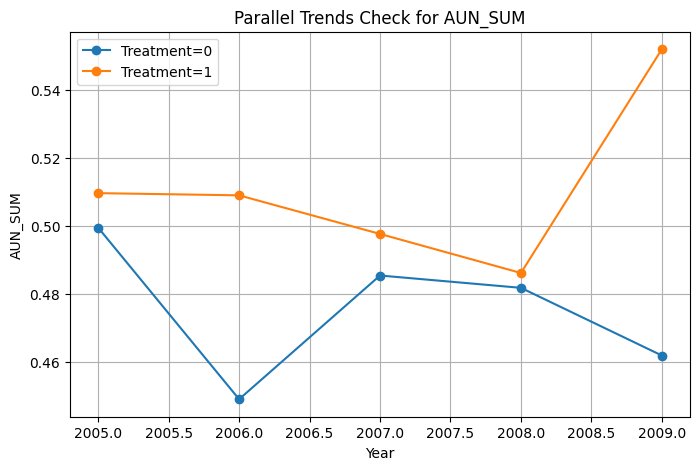

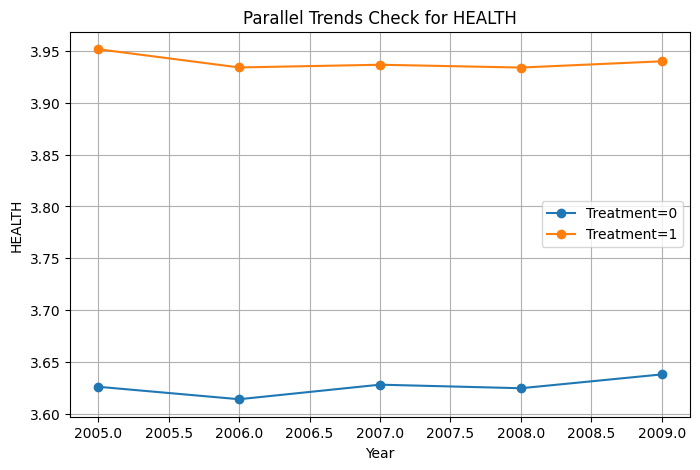

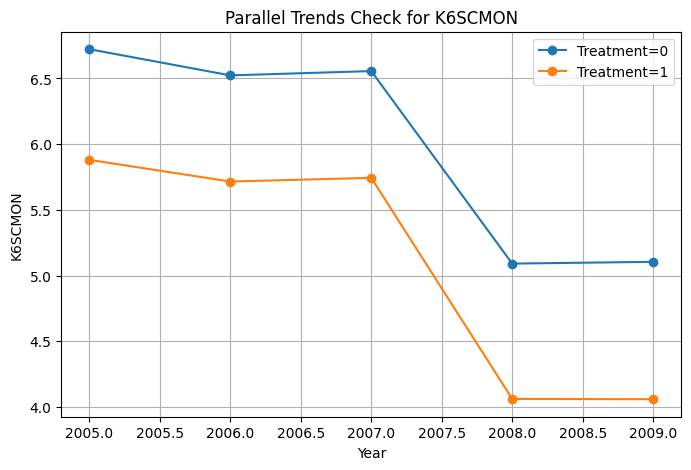

In [17]:
import matplotlib.pyplot as plt

# 처치 이전 데이터만 필터링 (2010년 이전)
pre_treatment_data = data[data['YEAR'] < 2010]

# 처리 그룹과 비처리 그룹의 연도별 평균 계산
grouped = pre_treatment_data.groupby(['YEAR', 'Treatment'])[numeric_outcomes].mean().reset_index()

# 시각화
for outcome in numeric_outcomes:
    plt.figure(figsize=(8, 5))
    for treatment in [0, 1]:
        subset = grouped[grouped['Treatment'] == treatment]
        plt.plot(subset['YEAR'], subset[outcome], marker='o', label=f'Treatment={treatment}')
    plt.title(f'Parallel Trends Check for {outcome}')
    plt.xlabel('Year')
    plt.ylabel(outcome)
    plt.legend()
    plt.grid(True)
    plt.show()


# Did weighting go well?

In [6]:
# 1. Covariate Balance Check
from sklearn.metrics import mean_squared_error

# 처리 그룹과 비교 그룹 분리
mask_treated = (data['Treatment'] == 1)
mask_control = ~mask_treated

# 공변량의 평균 차이 확인
covariates = X.columns
balance_check = {
    covariate: {
        'Treated Mean': data.loc[mask_treated, covariate].mean(),
        'Control Mean': data.loc[mask_control, covariate].mean(),
        'Mean Difference': abs(data.loc[mask_treated, covariate].mean() - data.loc[mask_control, covariate].mean())
    }
    for covariate in covariates
}

# 결과 출력
print("\nCovariate Balance Check:")
for covariate, stats in balance_check.items():
    print(f"{covariate}: Treated Mean = {stats['Treated Mean']:.4f}, Control Mean = {stats['Control Mean']:.4f}, Mean Diff = {stats['Mean Difference']:.4f}")



Covariate Balance Check:
AGE2: Treated Mean = 0.4994, Control Mean = 0.4910, Mean Diff = 0.0084
IRSEX: Treated Mean = 1.5278, Control Mean = 1.5497, Mean Diff = 0.0219
INCOME: Treated Mean = 0.6377, Control Mean = 0.3313, Mean Diff = 0.3064
IRMARIT: Treated Mean = 2.4683, Control Mean = 2.9304, Mean Diff = 0.4621
SERVICE: Treated Mean = 1.9433, Control Mean = 1.9356, Mean Diff = 0.0078
CG30EST: Treated Mean = 0.0005, Control Mean = 0.0016, Mean Diff = 0.0011
AL30EST: Treated Mean = 0.0001, Control Mean = 0.0001, Mean Diff = 0.0001
IRHHSIZ2: Treated Mean = 0.4223, Control Mean = 0.4485, Mean Diff = 0.0262
NOBOOKY2: Treated Mean = 0.0090, Control Mean = 0.0269, Mean Diff = 0.0179
COCFLAG: Treated Mean = 0.1468, Control Mean = 0.1697, Mean Diff = 0.0229
COCYR: Treated Mean = 0.0270, Control Mean = 0.0385, Mean Diff = 0.0116
EDUCCAT2: Treated Mean = 0.7370, Control Mean = 0.5788, Mean Diff = 0.1582
JBSTATR2: Treated Mean = 1.3731, Control Mean = 2.7411, Mean Diff = 1.3680
TXEVER: Treated 

In [8]:
# 추가 분석: Doubly Robust 추정기 평가
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.utils import resample
import matplotlib.pyplot as plt

# 1. 처치 모델 성능 평가 (ROC-AUC, Log-Loss)
roc_auc = roc_auc_score(T, propensity_scores)
logloss = log_loss(T, propensity_scores)
print(f"Treatment Model ROC-AUC: {roc_auc:.4f}")
print(f"Treatment Model Log-Loss: {logloss:.4f}")

Treatment Model ROC-AUC: 0.7829
Treatment Model Log-Loss: 0.5578


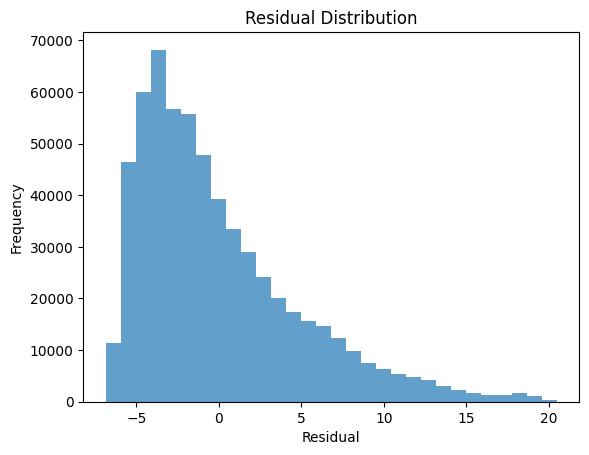

In [10]:
# 3. 잔차 분석
residuals = Y - ols_model.predict(X_ols)
plt.hist(residuals, bins=30, alpha=0.7)
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [11]:
# 4. Placebo Test
import numpy as np
np.random.seed(42)
data['Fake_Treatment_Post'] = np.random.choice([0, 1], size=len(data))

X_with_fake = X_with_ps.copy()
X_with_fake['Fake_Treatment_Post'] = data['Fake_Treatment_Post']
X_fake_ols = add_constant(X_with_fake[['Propensity', 'Post', 'Fake_Treatment_Post']])
ols_model_fake = OLS(Y, X_fake_ols).fit()

ate_fake = ols_model_fake.params['Fake_Treatment_Post']
ci_fake = ols_model_fake.conf_int().loc['Fake_Treatment_Post']
print(f"\nPlacebo Test: ATE for Fake Treatment: {ate_fake:.4f}, CI: ({ci_fake[0]:.4f}, {ci_fake[1]:.4f})")



Placebo Test: ATE for Fake Treatment: 0.0095, CI: (-0.0152, 0.0343)


# DiD Results

In [1]:
!pip install stargazer

In [4]:
from stargazer.stargazer import Stargazer
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Load your dataset
# data = pd.read_csv('your_data.csv')  # Uncomment and replace with your dataset path

numeric_outcomes = ["AUN_SUM", "HEALTH", "K6SCMON"]
results = {}
models = []

# Loop over numeric outcomes
for outcome in numeric_outcomes:
    print(f"Estimating effect for numeric outcome (DiD + Parametric): {outcome}")

    # Define variables
    Y = data[outcome]
    T = data["Treatment"]
    Post = data["Post"]  # DiD time variable
    X = data.drop(columns=["Treatment", "Post"] + numeric_outcomes)

    # Calculate propensity scores
    prop_model = LogisticRegression()
    prop_model.fit(X, T)
    propensity_scores = prop_model.predict_proba(X)[:, 1]

    # Add propensity score, treatment, and post to features
    X_with_ps = X.copy()
    X_with_ps['Propensity'] = propensity_scores
    X_with_ps['Post'] = Post
    X_with_ps['Treatment_Post'] = T * Post

    # Run OLS regression
    X_ols = add_constant(X_with_ps[['Propensity', 'Post', 'Treatment_Post']])
    ols_model = OLS(Y, X_ols).fit()

    # Store the model for stargazer
    models.append(ols_model)

# Generate Stargazer table
stargazer = Stargazer(models)
stargazer.title("Canonical DiD (with Propensity Scores) Results")
stargazer.custom_columns(numeric_outcomes, [1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

# Save to HTML file
with open("results_table.html", "w") as f:
    f.write(stargazer.render_html())

print("Table saved as 'results_table.html'.")


Estimating effect for numeric outcome (DiD + Parametric): AUN_SUM
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Estimating effect for numeric outcome (DiD + Parametric): HEALTH
Estimating effect for numeric outcome (DiD + Parametric): K6SCMON
Table saved as 'results_table.html'.


# HTE Results

In [10]:
from stargazer.stargazer import Stargazer
from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Map scaled income groups to original group numbers
income_group_mapping = {0: 1, 0.3333333333333333: 2, 0.6666666666666666: 3, 1: 4}
data['Mapped_Income'] = data['INCOME'].map(income_group_mapping)

# Generate Stargazer table for each outcome
for outcome, models in models_by_group.items():
    # Create labels for each income group using the mapped group numbers
    income_groups = [f"Group {income_group_mapping[i]}" for i in np.unique(data["INCOME"])]
    
    # Initialize Stargazer with models
    stargazer = Stargazer(models)
    stargazer.title(f"HTE by Income Group for {outcome}")
    
    # Assign custom columns
    stargazer.custom_columns(income_groups, [1] * len(income_groups))
    stargazer.show_model_numbers(False)
    stargazer.significant_digits(3)
    
    # Save to HTML file
    file_name = f"hte_results_{outcome}.html"
    with open(file_name, "w") as f:
        f.write(stargazer.render_html())
    
    print(f"Table for {outcome} saved as '{file_name}'.")


Table for AUN_SUM saved as 'hte_results_AUN_SUM.html'.
Table for HEALTH saved as 'hte_results_HEALTH.html'.
Table for K6SCMON saved as 'hte_results_K6SCMON.html'.
